# Modelo clasificador de reconocimiento facial
Lázaro R. Díaz Lievano.

## importancion de paqueterias 

In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from tensorflow.keras.optimizers import RMSprop, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.utils import load_img
import os

## Carga de datos de entrenamiento, validacion y prueba

Aqui indicamos las carpetas en donde se encuentran las imagenes que usaremos en el modelo. Tanto los conjuntos de Train como Validation contienen a su vez dos carpetas: una con fotos mias y otra con fotos de otras personas que fueron tomadas de la base de datos de CelebA. Por su parte, el conjunto de test contiene una carpeta con imagenes mezcladas mias y de otras personas, dado que con este conjunto de prueba será con el que evaluemos el modelo.

In [10]:
train_dir = r'C:/Users/Lazaro Diaz/RNA_otono2022/Reconocimiento facial/train' #directorio de entrenamiento
val_dir =  r'C:/Users/Lazaro Diaz/RNA_otono2022/Reconocimiento facial/val'
test_dir = r'C:/Users/Lazaro Diaz/RNA_otono2022/Reconocimiento facial/test' #directorio de prueba



## Generación de imagenes nuevas

Usaremos el operador ImageDataGenerator para aplicarle transformaciones a nuestras imagenes, como normalizar las intensidades de los tonos, rotaciones y redimensionar el tamaño de las imagenes con el fin de obtener datos uniformes y más fáciles de analizar para la red.

transformacion de imagenes con ImageDataGenerator. Se intentó de 2 formas distintas. 

### 1. Creando imagenes para el conjunto train y guardandolas en disco.

In [184]:
ih = 192
iw=  192

imagenes_generadas_folder = 'new_imageA'
n_imagenes_des = 5

try:
    os.mkdir(imagenes_generadas_folder)
except:
    print("")
    
#hacemos que la generacion de imagenes se base en transformaciones como rotaciones, zoom, desplazamientos y voltear la imagen tipo modo espejo.    
train_datagen = ImageDataGenerator(rescale = 1./255., 
                                   rotation_range=20, 
                                   zoom_range=0.2,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True, 
                                   vertical_flip=False)

train_lazaro_dir = "C:/Users/Lazaro Diaz/RNA_otono2022/Reconocimiento facial/train/Lazaro"
data_dir_list = os.listdir(train_lazaro_dir)

i=0
num_images=0


for image_file in data_dir_list:
    img_list=os.listdir(train_lazaro_dir)

    img_path = train_lazaro_dir+'/'+image_file #directorio de cada imagen dentro de la carpeta "Lazaro"
    
    imge=tf.keras.utils.image_dataset_from_directory(img_path) #lectura de imagen 
    
    imge=tf.image.resize(tf.keras.utils.img_to_array(imge), (iw, ih))  #redimension la imagen a (192, 192) y pasarla a un array
    
  
    x=imge/255. #normalizacion
    
    x=np.expand_dims(x, axis=0)
    m=1
    for output_batch in train_datagen.flow(x, batch_size=1):
        a=tf.keras.utils.img_to_array(output_batch[0])  #transforma cada imagen a un array
        img=output_batch[0,:,:]*255. #desnormaliza
        img_gen = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #lo pasamos a color RGB
        cv2.imwrite(imagenes_generadas_folder+"/%i%i.jpeg"%(i,t), imagen_gen) #se usa para guardar la imagen generada
        #cv2.imwrite(directorio, imagen)
        m+=1
        
        num_images+=1
        if m>n_imagenes_des:
            break
    i+=1
    
print("imagenes generadas: ", num_images)

NotFoundError: Could not find directory C:/Users/Lazaro Diaz/RNA_otono2022/Reconocimiento facial/train/Lazaro/0001.jpeg

En este caso, no entiendo por qué me da este error dado que este directorio sí existe y corresponde a la primera imagen de mi rostro.

### 2. Creando imagenes conforme se entrena la red.

Generacion de imagenes nuevas con imageDataGenerator

Con el método flow_from_directory() podemos leer las imágenes directamente desde el directorio y transformarlas mientras el modelo esta entrenando.

In [167]:
#fijamos unos parametros
num_class = 2   #cuantas clases
epochs = 100   #cuantas veces entrenar. En cada epoch hace una mejora en los parametros
batch_size = 20   #batch para hacer cada entrenamiento. Lee 20 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 143   #numero de imagenes en train
num_val = 27
num_test = 36   #numero de imagenes en test
iw, ih = 192,192

In [168]:
#en este caso los directorios estan de más, dado que ya se definieron arriba, pero sirve para visualizar lo que se hace.
train_d = r"C:/Users/Lazaro Diaz/RNA_otono2022/Reconocimiento facial/train"
val_d = r"C:/Users/Lazaro Diaz/RNA_otono2022/Reconocimiento facial/val"
test_d = r"C:/Users/Lazaro Diaz/RNA_otono2022/Reconocimiento facial/test"
   
#tipos de transformaciones en las que se basa la generacion de imagenes

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range=30,
                                   zoom_range=0.15,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   horizontal_flip=True, 
                                   vertical_flip=False 
                                   )

val_datagen = ImageDataGenerator(rescale = 1./255.)



train_generator = train_datagen.flow_from_directory(
    train_d,
    target_size=(iw, ih),
    batch_size=batch_size,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_d,
    target_size=(iw, ih),
    batch_size=batch_size,
    class_mode='binary')

test = val_datagen.flow_from_directory(
    test_d,
    target_size=(iw, ih),
    batch_size=batch_size,
    class_mode='binary')

Found 143 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
Found 36 images belonging to 1 classes.


In [169]:
epoch_steps = num_train // batch_size
val_steps = num_val // batch_size
test_steps = num_test // batch_size

Dado que este metodo usando flow_from_directory funciona, entrenaremos el modelo con estos datos.

## Cargado del modelo pre-entrenado que identifica atributos en imagenes de rostros.

La esencia de este modelo es que yo no tengo suficientes fotos mias como para entrenar el modelo eficientemente desde cero, asi que se entrenó el modelo 1: identificador de atributos en imagenes para que pudiera identificar atributos en imagenes de rostros y una vez que el modelo ya puede identificar ciertas características en un rostro, ahora sí puedo entrenarlo con fotos mías, esta técnica es conocida como **Transfer Learning**, se entrena un modelo inicialmente con una base de datos amplia y una vez entrenado podemos darle nuevos datos y que aprenda a reconocerlos.

In [170]:
from keras.models import load_model

path_model = 'C:/Users/Lazaro Diaz/RNA_otono2022/Reconocimiento facial/rna_attrib.h5'

pre_trained_model = load_model(path_model)
pre_trained_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 190, 40)      1120      
                                                                 
 activation (Activation)     (None, 190, 190, 40)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 40)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 93, 80)        28880     
                                                                 
 activation_1 (Activation)   (None, 93, 93, 80)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 80)       0         
 2D)                                                    

Las capas que utilizaremos en este nuevo modelo son las capas convolucionales y el flatten, las cuales ya fueron pre entrenadas por lo que ya no es necesario volver a entrenar sus pesos desde cero. 
Asi, entrenamos la red con los pesos de las capas convolucionales fijas y los unicos pesos que se modifican son las del *clasificador*.

In [171]:
pre_trained_model.layers[:10]

## Estructura de la red neuronal clasificadora 

Basicamente este modelo se conforma de las capas convolucionales con los pesos ya entrenados del modelo anterior de identificacion de atributos en rostros y se agregaron capas densas que hacen la función del clasificador, cuya funcion es que al entrenar estas ultimas capas puedan clasificar correctamente si en una imagen de rostro soy yo o no.

In [172]:
model = keras.models.Sequential()

#capas convolucionales pre entrenadas
model.add(pre_trained_model.layers[0])
model.add(pre_trained_model.layers[1])
model.add(pre_trained_model.layers[2])
model.add(pre_trained_model.layers[3])
model.add(pre_trained_model.layers[4])
model.add(pre_trained_model.layers[5])
model.add(pre_trained_model.layers[6])
model.add(pre_trained_model.layers[7])
model.add(pre_trained_model.layers[8])
model.add(pre_trained_model.layers[9])

#clasificador
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(1))
model.add(Activation("sigmoid"))

#congelamos los pesos de las capas pre entrenadas, es decir, de las redes convolucionales y el flatten.
for layer in pre_trained_model.layers[:10]:
    layer.trainable = False

## Entrenamiento del modelo clasificador  

In [173]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])

In [174]:
model_history = model.fit(
    train_generator,
    batch_size = batch_size,
    epochs = 20,
    verbose = 1, 
    validation_data = val_generator)

Epoch 1/20
8/8 [==============================] - 5s 531ms/step - loss: 0.6915 - accuracy: 0.5804 - val_loss: 0.6936 - val_accuracy: 0.6667
Epoch 2/20
8/8 [==============================] - 4s 497ms/step - loss: 0.6913 - accuracy: 0.5245 - val_loss: 0.6922 - val_accuracy: 0.7037
Epoch 3/20
8/8 [==============================] - 4s 510ms/step - loss: 0.6896 - accuracy: 0.6014 - val_loss: 0.6908 - val_accuracy: 0.7037
Epoch 4/20
8/8 [==============================] - 4s 501ms/step - loss: 0.6871 - accuracy: 0.6853 - val_loss: 0.6893 - val_accuracy: 0.7037
Epoch 5/20
8/8 [==============================] - 4s 502ms/step - loss: 0.6894 - accuracy: 0.5874 - val_loss: 0.6877 - val_accuracy: 0.7407
Epoch 6/20
8/8 [==============================] - 4s 500ms/step - loss: 0.6871 - accuracy: 0.6503 - val_loss: 0.6859 - val_accuracy: 0.7778
Epoch 7/20
8/8 [==============================] - 4s 561ms/step - loss: 0.6839 - accuracy: 0.7063 - val_loss: 0.6842 - val_accuracy: 0.8148
Epoch 8/20
8/8 [====

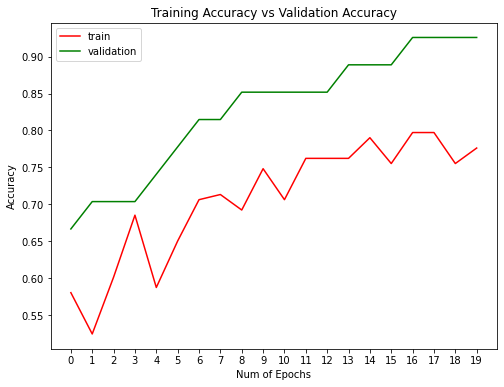

In [177]:
plt.plot(model_history.history['accuracy'],'r')  
plt.plot(model_history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 20, 1.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

In [178]:
model.save("rna_clasificador_rec_facial.h5")